In [10]:
import obspy, glob
import os, glob
import numpy as np
import pandas as pd
import numpy.matlib
from obspy import Trace, UTCDateTime, Stream
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from scipy import signal, ndimage
from scipy.io.wavfile import read, write
import cv2
import dask
import dask_image.ndfilters
import dask.array
from datetime import datetime, date, timedelta
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [105]:
path = '/Volumes/Data/Soundscape/03_TaoYuan/2023/20230608-20230623/wav'
place = path.rsplit('/')[4].rsplit('_')[1]


S = -176.1 # end to end 
P_ref = 1 # water: 1 uPa
interval = 10 # sec
fmin = 500 # Hz
fmax = 6000 # Hz

# local_cluster = LocalCluster(n_workers=2, processes=False, threads_per_worker=16)

In [63]:
def calib(data, S):
    audio_data = data.astype(np.float32, order='C') / 32768.0
    calib_data = audio_data / ((10)**(S/20))
    return calib_data # uPa

          
def spectrogram(data, sampling_frequency, window='hann', fmin=200, fmax=1000, verbose=False):
    if verbose:
        print('--------------- Calculate spectro.')
    length = 256
    f,t,P = signal.stft(data, fs= sampling_frequency, window='hann', 
                        nperseg=length, noverlap=int(0.9*length), 
                        nfft=8000, detrend='constant', boundary=None, padded=False)
    data = 10*np.log10(np.abs(P)/np.power(1, 2))
    # f, t, spect = signal.spectrogram(
    #                 data,
    #                 fs=sampling_frequency,
    #                 window=window,
    #                 nperseg=int(sampling_frequency/20),
    #                 noverlap=int(sampling_frequency/20*0.9),
    #                 nfft=2**16,
    #                 scaling="spectrum" )
    
    fmin_idx = np.where(f <= fmin)[0][-1]+1
    fmax_idx = np.where(f <= fmax)[0][-1]-1
    f = f[fmin_idx:fmax_idx]
    data = data[fmin_idx:fmax_idx, :]
    #spect = spect[fmin_idx:fmax_idx, :]
    return f, t, data

def denoise(spect, duration=10, time_resolution=0.005, use_dask=True, verbose=False):
    Smed = np.percentile(spect, 50, axis=1)
    input_data = np.subtract(spect, np.matlib.repmat(Smed, spect.shape[1], 1).T)
    input_data[input_data < 0] = 0
#     if use_dask:
        
#         dask_spectro = dask.array.from_array(spect, chunks=[1000,1000])
#         Smed = dask_image.ndfilters.percentile_filter(
#             dask_spectro, 50,
#             size=(1, round(duration / time_resolution)),
#             mode="mirror",
#         )
#         Smed = Smed.compute()
#     else:
#         Smed = ndimage.percentile_filter(
#                 spect, 50,
#                 (1, round(duration / time_resolution)) ) 
      
#     spect = spect - Smed
#     spect[spect < 0] = 0  # floor
    
    return input_data
def detect(t, f, spect, tr, starttime, kernel_duration=0.05, kernel_bandwidth=300, threshold_pct=90, f_noise=None, use_dask=False, verbose=False):
    if verbose:
        print('--------------- Calculate detection.  ')
    f_res = f[1]-f[0]
    t_res = round(t[1]-t[0], 5)
    kernel_duration = max(round(kernel_duration/t_res), 1) #sec to pt
    kernel_bandwidth = max(round(kernel_bandwidth/f_res), 1) #Hz to pt
    if use_dask:
        dask_spectro = dask.array.from_array(spect, chunks=[1000,1000])
        Svar = dask_image.ndfilters.generic_filter(dask_spectro,
                                                   calcVariance2D,
                                                   size=(kernel_bandwidth, kernel_duration),
                                                   mode='mirror')
        Svar = Svar.compute()
    else:
        imx = np.zeros(spect.shape)
        Svar = ndimage.generic_filter(spect,
                                  calcVariance2D,
                                  (kernel_bandwidth, kernel_duration),
                                  mode='mirror')
        # Svar = ndimage.generic_filter(spect,
        #                           calcVariance2D,
        #                           (kernel_bandwidth, kernel_duration),
        #                           mode='mirror')
        
    # binarization
    threshold = np.percentile(Svar, threshold_pct, interpolation='linear')
    Svar[Svar < threshold] = 0
    Svar[Svar > 0] = 1
    
    
    Svar_gray = cv2.normalize(src=Svar,
                              dst=None,
                              alpha=0,
                              beta=255,
                              norm_type=cv2.NORM_MINMAX,
                              dtype=cv2.CV_8UC1)
    (cnts, hierarchy) = cv2.findContours(Svar_gray.copy(),
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_SIMPLE)   
    cnts_sorted = sorted(list(cnts),key=lambda d: d[0][0][0])
    # loop over the contours
    isdetec = False
    t1 = []; t2 = []
    fmin = []; fmax = []
    
    for ii, c in enumerate(cnts_sorted):
        # Compute the bounding box for the contour
        (x, y, w, h) = cv2.boundingRect(c)
        if w < kernel_duration or h < kernel_bandwidth: # if the contour is too small, ignore it
            continue
        elif h >= round((f[-1]-f[0])/f_res, 2)*0.85 and w*t_res < 0.02: ## avoid short and broadband-noise 
            #print('broadband-noise', w)
            continue
        elif f_noise is not None:
            data_detect = np.sum(spect[:, x:x+w-1],axis=1) 
            data_ori = np.sum(spect, axis=1) 
            coeff = np.corrcoef(data_ori, data_detect)[0,1]
            if abs(coeff) >= 0.8:
                pass
            else:
                t1.append(x); t2.append(x+w-1) 
                fmin.append(y); fmax.append(y+h-1) 
            # if abs(peak_f_detect-f_noise) > 30 : ## avoid continous noise
            #     t1.append(x); t2.append(x+w-1) 
            #     fmin.append(y); fmax.append(y+h-1) 
            # else:
            #     print(peak_f_detect)
            #     pass
        else:
            isdetec = True

            if len(t1)>0 and t2[-1]>=x>=t1[-1]:    ## avoid repeated detection
                _fmin = fmin[-1]; _fmax = fmax[-1]
                if y<_fmin :
                    fmin[-1] = y
                if (y+h-1)>_fmax:
                    fmax[-1] = y+h-1
                continue
            else:
                t1.append(x); t2.append(x+w-1) # box coord
                fmin.append(y); fmax.append(y+h-1)   
    
    detec = {} 
    detec['time_min_offset'] = [t[0]+_t*t_res for _t in t1]
    detec['time_max_offset'] = [t[0]+_t*t_res for _t in t2]
    detec['frequency_min'] = [f[_f] for _f in fmin]
    detec['frequency_max'] = [f[_f] for _f in fmax]
    detec['duration'] = np.array(detec['time_max_offset']) - np.array(detec['time_min_offset'])
    detec['time_min_date'] = [starttime+_t*t_res+t[0] for _t in t1] 
    detec['time_max_date'] = [starttime+_t*t_res+t[0] for _t in t2]
    detec['SPLpp'] = [ SPL_PP(tr, t1, t2) for t1, t2 in zip(detec['time_min_date'], detec['time_max_date'])]
    detec['peaks'] = [ findpeaks(tr, t1, t2, fmin, fmax) for t1, t2, fmin, fmax in zip(detec['time_min_date'], detec['time_max_date'], detec['frequency_min'], detec['frequency_max'])]
    detec = pd.DataFrame(detec)
    detec.sort_values('time_min_offset',
                       ascending=True,
                       inplace=True,
                       ignore_index=True )
    return Svar, detec, cnts_sorted

def findpeaks(tr, t1, t2, fmin, fmax):
    tr_temp = tr.slice(t1, t2)
    tr_temp = tr_temp.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
    from scipy.signal import find_peaks
    x = tr_temp.data/np.max(tr_temp.data)
    peaks, _ = find_peaks(x, height=0.75, distance=1000)
    return len(peaks)

def calcVariance2D(buffer):
    """Calculate the 2D variance."""
    return np.var(buffer)
    # return np.median(buffer.ravel())
    # return np.mean(buffer.ravel())
    
def plot_annot(detectfile, ax, type='spectrogram', color='red'):
    if type == 'spectrogram':
        alpha = 0.7
        facecolor = "none"
        color = color
        label='detected'
        line_width = 0.7
        for index, row in detectfile.iterrows():
            x = row["time_min_offset"]
            y = row["frequency_min"]
            width = row["duration"]
            height = row["frequency_max"] - row["frequency_min"]
            import matplotlib.patches as patches
            rect = patches.Rectangle((x, y), width, height, linewidth=line_width, edgecolor=color, facecolor=facecolor, alpha=alpha)
            ax.add_patch(rect)  
    elif type == 'waveform':
        alpha = 0.1
        facecolor = color
        color='none'
        label='detected'
        line_width = 0.5
        for index, row in detectfile.iterrows():
            x = row["time_min_offset"]
            y = min(ax.get_ylim())
            width = row["duration"]
            height = max(ax.get_ylim()) - min(ax.get_ylim())
            
            import matplotlib.patches as patches
            rect = patches.Rectangle((x, y), width, height, linewidth=line_width, edgecolor=color, facecolor=facecolor, alpha=alpha)
            ax.add_patch(rect)  
    return ax

def SPL_PP(tr, t1, t2):
    P_ref = 1
    tr_sound = tr.slice(t1, t2)
    p_peak = max(tr_sound.data)+abs(min(tr_sound.data))
    P_spl = 20*np.log10(p_peak/P_ref)
    return P_spl

def continuous_singal(f, data):
    dev_f_peak = []
    t_shape = data.shape[1]
    for i in range(0, t_shape, 400):
        data_tmp = data[:, i:i+400]
        Emax_freq = Peak_frequency(f, data_tmp)
        if i != 0:
            if abs(previous_Emax_freq-Emax_freq) <= 30:
                dev_f_peak.append(True)
            else:
                dev_f_peak.append(False)
            previous_Emax_freq = Emax_freq
        else:
            previous_Emax_freq = Emax_freq
    if dev_f_peak[:3] == [True]*3 or dev_f_peak[1:] == [True]*3:
        Emax_freq = Peak_frequency(f, data)
        return True, Emax_freq
    else:
        return False, None  
    
# def continuous_singal(f, data):
#     dev_f_peak = []
#     t_shape = data.shape[1]
#     for i in range(0, t_shape, 400):
#         data_tmp1 = np.sum(data[:, i:i+400],axis=1)
#         if i<1600:
#             data_tmp2 = np.sum(data[:, i+400:i+800],axis=1)
#             coeff = np.corrcoef(data_tmp1, data_tmp2)[0,1]
#             if abs(coeff) >= 0.8:
#                 dev_f_peak.append(True)
#             else:
#                 dev_f_peak.append(False)
#     print(dev_f_peak)
#     if dev_f_peak[2:] == [True,True] or dev_f_peak[1:3] == [True,True] or dev_f_peak[:2] == [True,True] :
#         Emax_freq = Peak_frequency(f, data)
#         return True, Emax_freq
#     else:
#         return False, None  
    
    
def Peak_frequency(f, data):
    sum_energy = np.sum(data, axis=1)
    Emax_freq = f[np.argmax(sum_energy)]
    return Emax_freq

In [106]:
df_min = {'Time':[],
         'Peak': [],
         'MaxSPL': [], 
         'SPLrms':[]}
for file in glob.glob(f'{path}/????.23061919*.wav'):
    print(file)
    rate, data_ = read(file) 
    data = calib(data_, S)
    
    filetime = file.rsplit('.')[1]
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    if rate == 96000:
        tr.decimate(2, no_filter=True) 
    tr.stats.starttime = UTCDateTime(2023, int(filetime[2:4]), int(filetime[4:6]), int(filetime[6:8]), int(filetime[8:10]), int(filetime[10:]))
    tr_bp = tr.copy()
    tr_bp.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=6, zerophase=True)
    
    total_min = int(tr.stats.endtime - tr.stats.starttime)/60
    

#     for mm in range(int(total_min)):

print('finished ')

/Volumes/Data/Soundscape/03_TaoYuan/2023/20230608-20230623/wav/6979.230619190002.wav
finished 


In [107]:
tr_bp

... | 2023-06-19T19:00:02.000000Z - 2023-06-19T20:00:02.150146Z | 48000.0 Hz, 172807208 samples

## for plotting 

2650
--------------- Calculate spectro.
False None
--------------- Calculate detection.  
------------------PLOT
calculating time 0:21:57.991109


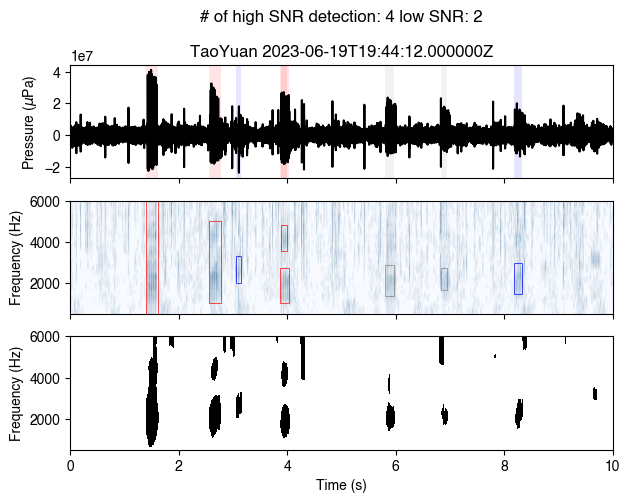

In [108]:
alldetect = pd.DataFrame([])
plot = True
save = False

verbose = True
if save:
    savepath = '/Volumes/home/Research/Detect_fish/Taoyuan'
    dirtime = file.rsplit('.')[1][:8]
    if not os.path.isdir(f'{savepath}_csv/{dirtime}'):
        os.mkdir(f'{savepath}_csv/{dirtime}')
        os.mkdir(f'{savepath}_fig/{dirtime}')
    
    

t0 = datetime.now()
total_sec = int(tr_bp.stats.endtime - tr_bp.stats.starttime)
for dt in np.arange(2650, 2660, 10): #total_sec, interval):
    print(dt)
    tr_cut = tr_bp.copy() 
    start  = tr_bp.stats.starttime + dt 
    end    = start + interval
    tr_cut = tr_cut.slice(starttime=start, endtime=end)
    tr_cut.data = tr_cut.data - np.median(tr_cut.data)

    
    f, t, spect = spectrogram(tr_cut.data, tr_cut.stats.sampling_rate,  fmin=fmin, fmax=fmax, verbose=verbose)
    
    spect_denoise = denoise(spect, verbose=verbose)
    cont_noise, freq_noise = continuous_singal(f, spect_denoise)
    print(cont_noise, freq_noise)
    Svar_, detec, cnts_sorted = detect(t, f, spect_denoise, tr_cut, starttime=tr_cut.stats.starttime, use_dask=True, \
                                       threshold_pct=95, f_noise=freq_noise, kernel_duration=0.1, kernel_bandwidth=1000, verbose=verbose)
    
    var_tr_cut = np.var(tr_cut.data)
    snrlist = []
    for ii in range(len(detec)):
        dect_start = detec['time_min_date'].values[ii]
        dect_end = detec['time_max_date'].values[ii]
        
        tr_dect = tr_cut.slice(dect_start, dect_end)
        var_tr_dect = np.var(tr_dect.data)
        snr = 10*np.log10(var_tr_dect/var_tr_cut)
        snrlist.append(snr)
            
    new_detec = pd.concat([detec, 
                           pd.DataFrame({'low_freq':[freq_noise]*len(detec), 'SNR': snrlist})], axis=1)
    # alldetect = pd.concat([alldetect, new_detec])
    
    if plot:
        print('------------------PLOT')
        fig, ax = plt.subplots(3, 1 ,figsize=(7, 5), sharex=True)
        plt.rc('font', family='Helvetica')
        ax[0].plot(tr_cut.times(), tr_cut.data, 'k')
        ax[0].set_xlim(tr_cut.times()[0], tr_cut.times()[-1])
        ax[0].set_ylabel('Pressure ($\mu$Pa)')
        

        ax[1].pcolormesh(t, f, spect_denoise, cmap="Blues",
                        vmin=np.percentile(spect_denoise, 90),
                        vmax=np.percentile(spect_denoise, 99.9),
                        shading="gouraud")
        ax[1].set_ylim(fmin, fmax)
        ax[1].set_ylabel('Frequency (Hz)')

        ax[2].pcolormesh(t, f, Svar_, cmap="binary")
        ax[2].set_ylim(fmin, fmax)
        ax[2].set_xlabel('Time (s)')
        ax[2].set_ylabel('Frequency (Hz)')
        
        low_peaks = new_detec[new_detec['peaks']  < 5]
        high_SNR = new_detec[new_detec['SNR'] >= 4][new_detec['peaks']  >= 5]
        low_SNR = new_detec[new_detec['SNR']  < 4.0][new_detec['SNR']  > 0][new_detec['peaks']  >= 5]

        ax[1] = plot_annot(low_peaks, ax[1], type='spectrogram', color='grey')
        ax[0] = plot_annot(low_peaks, ax[0], type='waveform', color='grey')
        ax[1] = plot_annot(high_SNR, ax[1], type='spectrogram', color='red')
        ax[0] = plot_annot(high_SNR, ax[0], type='waveform', color='red')
        ax[1] = plot_annot(low_SNR, ax[1], type='spectrogram', color='blue')
        ax[0] = plot_annot(low_SNR, ax[0], type='waveform', color='blue')
        if freq_noise is None:
            title = f'# of high SNR detection: {len(high_SNR)} low SNR: {len(low_SNR)}\n\n{place} {tr_cut.stats.starttime}'
        else:
            title = f'# of high SNR detection: {len(high_SNR)} low SNR: {len(low_SNR)}\nPeak frequency: {int(freq_noise)} Hz\n{place} {tr_cut.stats.starttime}'
        ax[0].set_title(title)
        if save:
            fig.savefig(f'{savepath}_fig/{dirtime}/{place}_{file.rsplit(".")[1]}_{dt}.png', dpi=150, transparent=True)
            plt.close()
            
    if save:
        new_detec.to_csv(f'{savepath}_csv/{dirtime}/{place}_{file.rsplit(".")[1]}_{dt}.csv', index=False)
    # del Svar_, detec, cnts_sorted, spect_denoise, spect
        
t1 = datetime.now()
print(f'calculating time {t1-t0}')
# fig.savefig('Example2.png', dpi = 200)

In [109]:
new_detec

,time_min_offset,time_max_offset,frequency_min,frequency_max,duration,time_min_date,time_max_date,SPLpp,peaks,low_freq,SNR
0,1.397487,1.622127,504.0,5988.0,0.22464,2023-06-19T19:44:13.397487Z,2023-06-19T19:44:13.622127Z,156.126705,14,None,6.364666
1,2.554167,2.769087,1050.0,5016.0,0.21492,2023-06-19T19:44:14.554167Z,2023-06-19T19:44:14.769087Z,154.138235,8,None,4.723795
2,3.049347,3.150327,2022.0,3330.0,0.10098,2023-06-19T19:44:15.049347Z,2023-06-19T19:44:15.150327Z,152.493911,6,None,3.225357
3,3.862587,4.038087,1050.0,2706.0,0.17550,2023-06-19T19:44:15.862587Z,2023-06-19T19:44:16.038087Z,153.160030,14,None,4.131803
4,3.875547,3.999747,3528.0,4818.0,0.12420,2023-06-19T19:44:15.875547Z,2023-06-19T19:44:15.999747Z,153.160030,20,None,4.495109
5,5.807127,5.969667,1374.0,2868.0,0.16254,2023-06-19T19:44:17.807127Z,2023-06-19T19:44:17.969667Z,151.359173,3,None,2.701357
6,6.831507,6.943827,1680.0,2712.0,0.11232,2023-06-19T19:44:18.831507Z,2023-06-19T19:44:18.943827Z,152.762179,2,None,2.177613
7,8.175567,8.318667,1482.0,2964.0,0.14310,2023-06-19T19:44:20.175567Z,2023-06-19T19:44:20.318667Z,150.553374,13,None,2.673256


In [76]:
fig, ax = plt.subplots(3, 1 ,figsize=(7, 5), sharex=True)
plt.rc('font', family='Helvetica')
ax[0].plot(tr_cut.times(), tr_cut.data, 'k')
ax[0].set_xlim(tr_cut.times()[0], tr_cut.times()[-1])
ax[0].set_ylabel('Pressure ($\mu$Pa)')


ax[1].pcolormesh(t, f, spect_denoise, cmap="Blues",
                vmin=np.percentile(spect_denoise, 95),
                vmax=np.percentile(spect_denoise, 99.9),
                shading="gouraud")
ax[1].set_ylim(fmin, fmax)
ax[1].set_ylabel('Frequency (Hz)')

ax[2].pcolormesh(t, f, Svar_, cmap="binary")
ax[2].set_ylim(fmin, fmax)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Frequency (Hz)')

low_peaks = new_detec[new_detec['peaks']  < 5]
high_SNR = new_detec[new_detec['SNR'] >= 3][new_detec['peaks']  >= 5]
low_SNR = new_detec[new_detec['SNR']  < 3.0][new_detec['SNR']  > 0][new_detec['peaks']  >= 5]

ax[1] = plot_annot(low_peaks, ax[1], type='spectrogram', color='grey')
ax[0] = plot_annot(low_peaks, ax[0], type='waveform', color='grey')
ax[1] = plot_annot(high_SNR, ax[1], type='spectrogram', color='red')
ax[0] = plot_annot(high_SNR, ax[0], type='waveform', color='red')
ax[1] = plot_annot(low_SNR, ax[1], type='spectrogram', color='blue')
ax[0] = plot_annot(low_SNR, ax[0], type='waveform', color='blue')

if freq_noise is None:
    title = f'# of high SNR detection: {len(high_SNR)} low SNR: {len(low_SNR)}\n\n{place} {tr_cut.stats.starttime}'
else:
    title = f'# of high SNR detection: {len(high_SNR)} low SNR: {len(low_SNR)}\nPeak frequency: {int(freq_noise)} Hz\n{place} {tr_cut.stats.starttime}'
ax[0].set_title(title)

Text(0.5, 1.0, '# of high SNR detection: 5 low SNR: 1\n\nTaoYuan 2023-06-19T19:44:12.000000Z')

Error in callback <function _draw_all_if_interactive at 0x12f8d45e0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1688574c0> (for post_execute):


KeyboardInterrupt: 

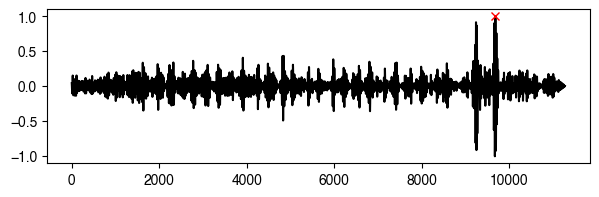

In [102]:

t1 = UTCDateTime('2023-06-19T19:06:46.870227Z	')
t2 = UTCDateTime('	2023-06-19T19:06:47.105127Z')
fmin = 1380
fmax= 2856
tr_temp = tr.slice(t1, t2)
tr_temp = tr_temp.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
from scipy.signal import find_peaks
x = tr_temp.data/np.max(tr_temp.data)
peaks, _ = find_peaks(x, height=0.75, distance=0.01*tr_temp.stats.sampling_rate)

plt.figure(figsize=(7,2))
plt.plot(x, 'k')
plt.plot(peaks, x[peaks], "x", color='r')

In [103]:
0.01*tr_temp.stats.sampling_rate

480.0

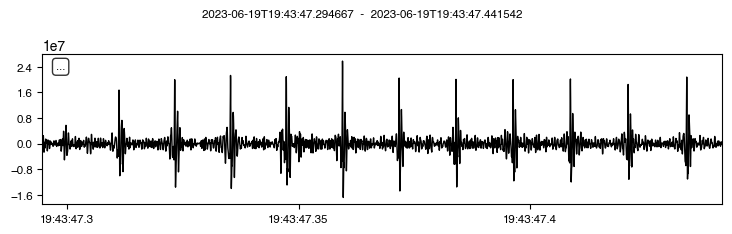

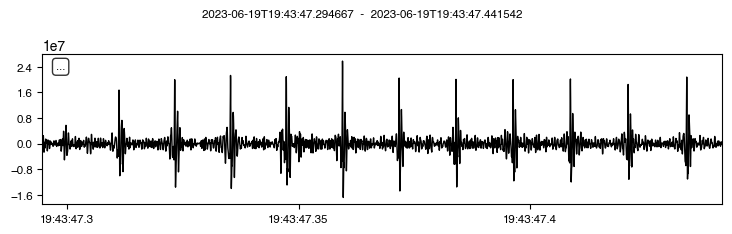

In [54]:
qqq = tr.slice(,)
qqq.filter('bandpass', freqmin=.0, freqmax=.0, corners=4, zerophase=True)
qqq.plot()

## to listen 

In [ ]:
for file in glob.glob(f'{path}/????.23062512*.wav'):
    print(file)
    rate, data_ = read(file) 
    data = calib(data_, S)
    
    filetime = file.rsplit('.')[1]
    tr = Trace()
    tr.data = data
    tr.stats.sampling_rate = rate
    if rate == 96000:
        tr.decimate(2, no_filter=True) 
    tr.stats.starttime = UTCDateTime(2023, int(filetime[2:4]), int(filetime[4:6]), int(filetime[6:8]), int(filetime[8:10]), int(filetime[10:]))
    tr_bp = tr.copy()
    tr_bp.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=6, zerophase=True)
    
filename = f"../Results/Detection_fishcall/99_tolisten/{place}_{file.rsplit('.')[1]}_downsampling_bp"
write(f'{filename}.wav', int(tr_bp.stats.sampling_rate), np.int16(tr_bp.data/np.max(np.abs(tr_bp.data)) * 32767))

print(f'finished {filename}')

In [382]:
file = glob.glob('/Volumes/Data-1/Soundscape/03_TaoYuan/2023/20231208-20231226/wav/7081.231226150003*')[0]
rate, data_ = read(file) 
data = calib(data_, S)

filetime = file.rsplit('.')[1]
tr = Trace()
tr.data = data
tr.stats.sampling_rate = rate
tr.stats.starttime = UTCDateTime(2023, int(filetime[2:4]), int(filetime[4:6]), int(filetime[6:8]), int(filetime[8:10]), int(filetime[10:]))

In [384]:
tr

... | 2023-12-26T15:00:03.000000Z - 2023-12-26T15:00:46.487823Z | 96000.0 Hz, 4174832 samples

In [392]:
datetime(2023,12,8,12,0) - datetime(2023,12,26,15,0)

datetime.timedelta(days=-19, seconds=75600)